In [1]:
# Data
from pymongo import MongoClient # For cluster connections, also requires dnspython package
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import os
import random
import re
import tqdm

# Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import preprocessor as p

# Gensim LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Lemmatization
import spacy # python -m spacy download en_core_web_sm

# Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dillo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
"""Set environment variable for connection string"""
%env MONGODB_CONNECTION=

In [14]:
class MongoDBConnect():
    """The Mongo database connector
    Args:
        host: host to connect
    """

    def __init__(self, host):
        self.host = host
        self.connection = None

    def __enter__(self):
        self.connection = MongoClient(self.host)
        print('Mongo connection created: {0}'.format(self.connection))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.connection.close()

    def get_all(self, collection, limit=0, order=1):
        """
        MongoDB get all items
        Args:
            collection: collection to get from
            limit: integer of limit of items to retrieve, ie, 1000, 2000, etc.
            order: datetime sort: asc 1, desc -1
        """
        try:
            collection = self.connection[urlparse(
                self.host).path[1:]][collection]
            items = collection.find().sort('created_at', order).limit(limit)  # oldest default, no limit default
            print('Successfully found {0} items'.format(items.count()))
            return items
        except Exception as e:
            print('PyMongo database error: {0}'.format(str(e)))
            raise e


In [ ]:
conn = os.getenv("MONGODB_CONNECTION")
with MongoDBConnect(conn) as db:
    items = db.get_all(collection="tweets")
    df = pd.DataFrame.from_dict(items)

In [79]:
# Load stop words and spacy nlp tokenizer
stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

In [80]:
# Clean tweets
def preprocess_tweet(text):
    return p.clean(text)

# Get hashtags
def preprocess_hashtags(text):
    hashtags = p.parse(df["tweet"][0]).hashtags
    return [hashtag.match for hashtag in hashtags]

In [81]:
# Preprocessing
df["hashtag"] = df["tweet"].apply(lambda x: preprocess_hashtags(x)) # Get hashtags for future analysis
df["tweet"] = df["tweet"].apply(lambda x: preprocess_tweet(x)) # Twitter preprocessing https://pypi.org/project/tweet-preprocessor/
data = df["tweet"].values.tolist() # Convert to list

In [41]:
# Tokenization, remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [42]:
# Build data words list
data_words = list(sent_to_words(data))

In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [44]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'PROPN']) # Keep only nouns, adj, verbs, and pronouns for topics

In [46]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [47]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [48]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.903824500763683

Coherence Score:  0.3587537949607213


In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [50]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.161915  0.224636       1        1  8.815600
7     -0.226971  0.215658       2        1  8.646385
0     -0.263657 -0.141940       3        1  7.633206
2      0.085580 -0.019813       4        1  7.343419
13    -0.164934 -0.310047       5        1  6.888908
14     0.087979 -0.010762       6        1  6.882547
1      0.117502  0.030191       7        1  6.790908
11     0.101048  0.047000       8        1  6.187918
10    -0.018513  0.061521       9        1  6.138048
9      0.100791 -0.026539      10        1  6.132011
5      0.020302 -0.025019      11        1  5.909953
8      0.095303 -0.006377      12        1  5.752980
12     0.100526 -0.016272      13        1  5.745148
3      0.080670 -0.037821      14        1  5.720292
6      0.046290  0.015584      15        1  5.412676, topic_info=     Category          Freq    Term         Total  loglift  logprob
29    Default  10428.000000     amp  10428.000000  30.0000  30.0000
23    Default  10936.000000   biden  10936.000000  29.0000  29.0000
15    Default  15118.000000   trump  15118.000000  28.0000  28.0000
94    Default   6115.000000  people   6115.000000  27.0000  27.0000
16    Default   6358.000000    vote   6358.000000  26.0000  26.0000
...       ...           ...     ...           ...      ...      ...
1186  Topic15    190.994202    shut    192.222977   2.9100  -5.0165
484   Topic15    183.499222    ball    184.687668   2.9100  -5.0566
3593  Topic15    174.511993   force    175.700424   2.9096  -5.1068
85    Topic15    269.464844   chief    272.279449   2.9060  -4.6723
188   Topic15    238.539322     guy   1500.545044   1.0774  -4.7942

[558 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2818      9  0.995064       able
222       3  0.997455    account
1352     14  0.994828        act
1599     10  0.997814     action
280      10  0.997184     actual
...     ...       ...        ...
58       11  0.101246       year
43       14  0.994353  years_ago
633       3  0.996924  yesterday
2835      8  0.995221         yo
1058     11  0.996856      young

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 1, 3, 14, 15, 2, 12, 11, 10, 6, 9, 13, 4, 7])

In [51]:
# World Cloud Plots
def create_word_cloud(topics, nrows, ncols, max_words=10):
    colors = [color for name, color in mcolors.CSS4_COLORS.items()]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=max_words,
                      colormap='tab20',
                      color_func=lambda *args, **kwargs: colors[i],
                      prefer_horizontal=1.0)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=500)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
        else:
            ax.axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

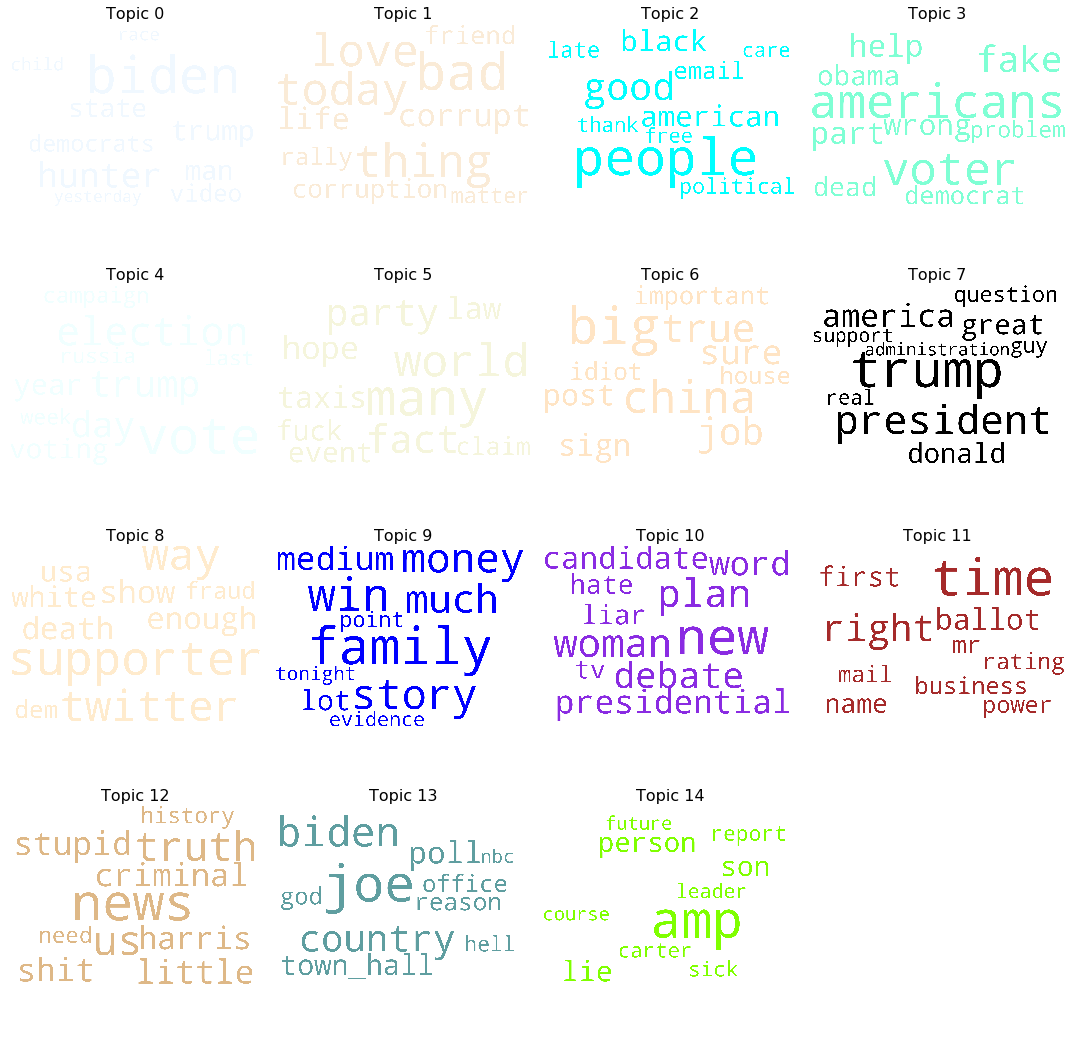

In [52]:
topics = lda_model.show_topics(formatted=False, num_topics=-1) # Get all topics
create_word_cloud(topics, 4, 4)

In [54]:
# Compute best k value for number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [55]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, \
                                                        corpus=corpus, \
                                                        texts=data_lemmatized, \
                                                        start=2, \
                                                        limit=40, \
                                                        step=5)

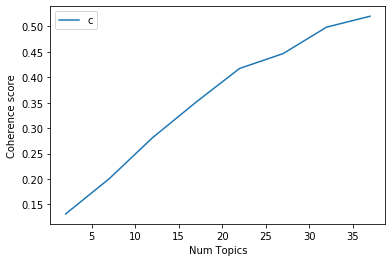

In [56]:
# Best k value
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Build LDA model
optimal_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=30, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

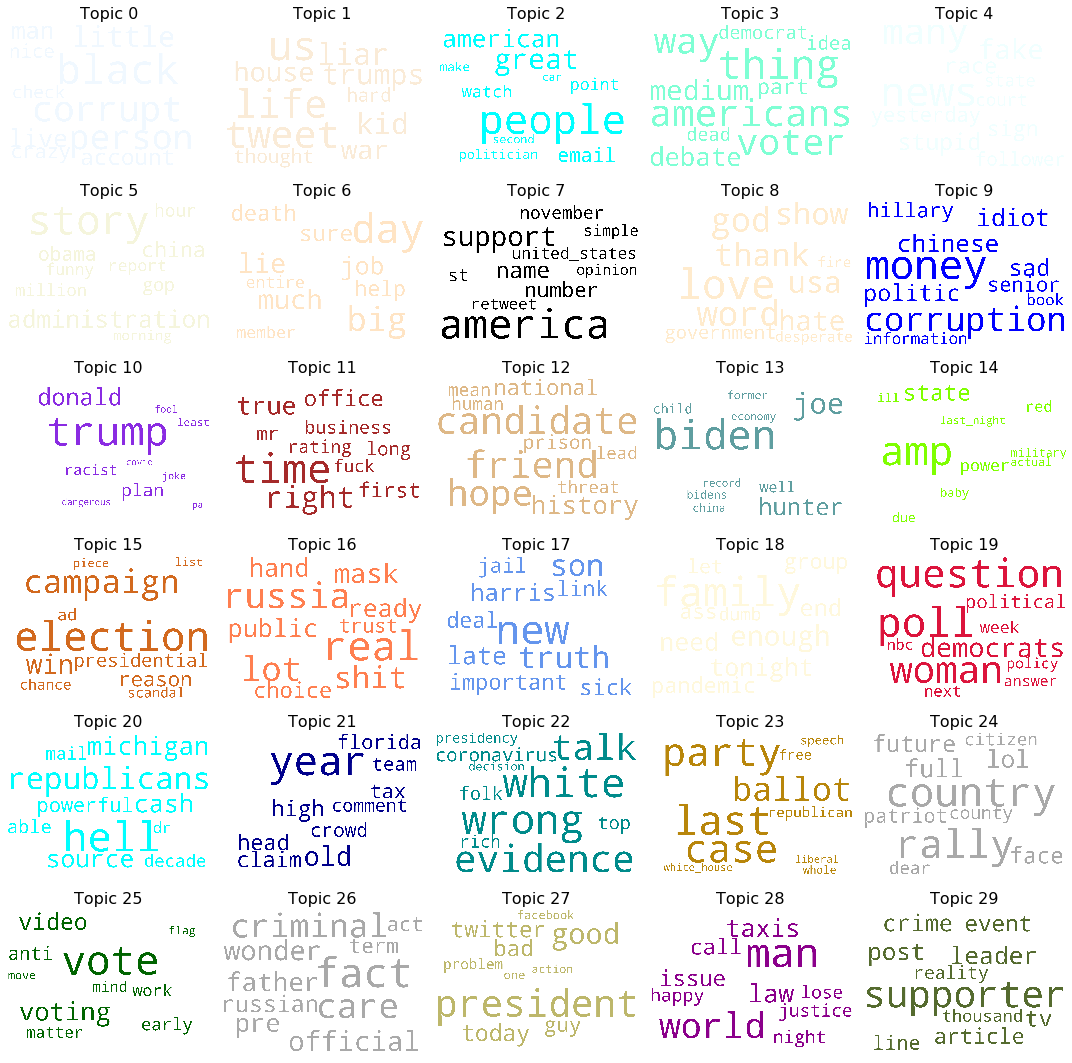

In [58]:
opt_topics = optimal_model.show_topics(formatted=False, num_topics=-1) # Get all topics
create_word_cloud(opt_topics, 6, 5)

In [109]:
# Top hashtags from each location